<h1> Feature Engineering </h1>

In this notebook, you will learn how to incorporate feature engineering into your pipeline.
<ul>
<li> Working with feature columns </li>
<li> Adding feature crosses in TensorFlow </li>
<li> Reading data from BigQuery </li>
<li> Creating datasets using Dataflow </li>
<li> Using a wide-and-deep model </li>
</ul>

Table of Contents:
<div id="toc"></div>

In [35]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [36]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import apache_beam

In [37]:
import google.datalab.ml as ml
import tensorflow as tf
# import apache_beam as beam
import shutil
print tf.__version__

1.4.1


In [38]:
import apache_beam as beam

<h2> 1. Environment variables for project and bucket </h2>

<li> Your project id is the *unique* string that identifies your project (not the project name). You can find this from the GCP Console dashboard's Home page.  My dashboard reads:  <b>Project ID:</b> cloud-training-demos </li>
<li> Cloud training often involves saving and restoring model files. Therefore, we should <b>create a single-region bucket</b>. If you don't have a bucket already, I suggest that you create one from the GCP console (because it will dynamically check whether the bucket name you want is available) </li>
</ol>
<b>Change the cell below</b> to reflect your Project ID and bucket name.


In [39]:
import os
PROJECT = 'coursera-192902'    # CHANGE THIS
BUCKET = 'single-bucket'  # CHANGE THIS
REGION = 'us-central1' # CHANGE THIS

Modify this path so that it works.  Essentially, /content is mapped in Datalab to where the home icon takes you. Then, you need to find where training_data_analyst is on your system relative to /content.

In [40]:
import os
REPO = "/content/datalab/training-data-analyst"
os.listdir(REPO)

['.ipynb_checkpoints',
 'Untitled Notebook.ipynb',
 'CPB100',
 'README.md',
 'quests',
 'self-paced-labs',
 'CONTRIBUTING.md',
 'LICENSE',
 '.git',
 '.gitignore',
 'courses',
 'datalab',
 'blogs']

In [41]:
# for bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['REPO'] = REPO

<h2> 2. Specifying query to pull the data </h2>

Let's pull out a few extra columns from the timestamp.

In [42]:
def create_query(phase, EVERY_N):
  """
  phase: 1 = train 2 = valid
  """
  base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """

  if EVERY_N == None:
    if phase < 2:
      # Training
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 < 2".format(base_query)
    else:
      # Validation
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 == {1}".format(base_query, phase)
  else:
      query = "{0} AND ABS(HASH(pickup_datetime)) % {1} == {2}".format(base_query, EVERY_N, phase)
    
  return query
    
print create_query(2, 100000)


SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
   AND ABS(HASH(pickup_datetime)) % 100000 == 2


Try the query above in https://bigquery.cloud.google.com/table/nyc-tlc:yellow.trips if you want to see what it does (ADD LIMIT 10 to the query!)

<h2> 3. Preprocessing Dataflow job from BigQuery </h2>

This code reads from BigQuery and saves the data as-is on Google Cloud Storage.  We can do additional preprocessing and cleanup inside Dataflow, but then we'll have to remember to repeat that prepreprocessing during inference. It is better to use tf.transform which will do this book-keeping for you, or to do preprocessing within your TensorFlow model. We will look at this in future notebooks. For now, we are simply moving data from BigQuery to CSV using Dataflow.

While we could read from BQ directly from TensorFlow (See: https://www.tensorflow.org/api_docs/python/tf/contrib/cloud/BigQueryReader), it is quite convenient to export to CSV and do the training off CSV.  Let's use Dataflow to do this at scale.

Because we are running this on the Cloud, you should go to the GCP Console (https://console.cloud.google.com/dataflow) to look at the status of the job. It will take several minutes for the preprocessing job to launch.

In [43]:
%bash
gsutil -m rm -rf gs://$BUCKET/taxifare/ch4/taxi_preproc/

Removing gs://single-bucket/taxifare/ch4/taxi_preproc/tmp/preprocess-taxifeatures-180122-221628.1516659388.764292/#1516659397413688...
Removing gs://single-bucket/taxifare/ch4/taxi_preproc/tmp/preprocess-taxifeatures-180122-221628.1516659388.764292/dax-tmp-2018-01-22_14_16_32-2958510776184452122-S01-0-38beca16b56c7417/#1516659397799072...
Removing gs://single-bucket/taxifare/ch4/taxi_preproc/tmp/preprocess-taxifeatures-180122-221628.1516659388.764292/dax-tmp-2018-01-22_14_16_32-2958510776184452122-S01-1-3cee3388804e6877/#1516659397742216...
Removing gs://single-bucket/taxifare/ch4/taxi_preproc/tmp/preprocess-taxifeatures-180122-221628.1516659388.764292/dax-tmp-2018-01-22_14_16_32-2958510776184452122-S10-0-44855e279edf4084/#1516659397742385...
Removing gs://single-bucket/taxifare/ch4/taxi_preproc/tmp/preprocess-taxifeatures-180122-221628.1516659388.764292/dax-tmp-2018-01-22_14_16_32-2958510776184452122-S10-1-4970415d1744a39b/#1516659397854623...
/ [5/5 objects] 100% Done                

In [44]:
import datetime
import apache_beam as beam 

def to_csv(rowdict):
  import copy
  days = ['null', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
  CSV_COLUMNS = 'fare_amount,dayofweek,hourofday,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key'.split(',')
  result = copy.deepcopy(rowdict)
  result['dayofweek'] = days[result['dayofweek']]
  return ','.join([str(result[k]) for k in CSV_COLUMNS])

def preprocess(EVERY_N, RUNNER):
  job_name = 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
  print 'Launching Dataflow job {} ... hang on'.format(job_name)
  OUTPUT_DIR = 'gs://{0}/taxifare/ch4/taxi_preproc/'.format(BUCKET)
  options = {
    'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
    'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
    'job_name': 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S'),
    'project': PROJECT,
    'teardown_policy': 'TEARDOWN_ALWAYS',
    'no_save_main_session': True
  }
  opts = beam.pipeline.PipelineOptions(flags=[], **options)
  p = beam.Pipeline(RUNNER, options=opts)
  for n, step in enumerate(['train', 'valid']):
    query = create_query(n+1, EVERY_N)
    outfile = os.path.join(OUTPUT_DIR, '{}.csv'.format(step))
    (
      p | 'read_{}'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query=query))
        | 'tocsv_{}'.format(step) >> beam.Map(to_csv)
        | 'write_{}'.format(step) >> beam.io.Write(beam.io.WriteToText(outfile))
    )

  p.run()

In [45]:
# Change as needed
#preprocess(50*100000, 'DirectRunner')  # runs locally
preprocess(50*1000, 'DataflowRunner') # runs on cloud; change first arg to None to preprocess full dataset

Launching Dataflow job preprocess-taxifeatures-180212-205618 ... hang on
[2018-02-12 20:56:19,398] {dependency.py:463} INFO - Staging the SDK tarball from PyPI to gs://single-bucket/taxifare/ch4/taxi_preproc/tmp/staging/preprocess-taxifeatures-180212-205618.1518468979.310195/dataflow_python_sdk.tar
[2018-02-12 20:56:19,403] {dependency.py:526} INFO - Executing command: ['/usr/bin/python', '-m', 'pip', 'install', '--download', '/tmp/tmpiHUtO3', 'google-cloud-dataflow==2.0.0', '--no-binary', ':all:', '--no-deps']
[2018-02-12 20:56:23,035] {dependency.py:88} INFO - file copy from /tmp/tmpiHUtO3/google-cloud-dataflow-2.0.0.tar.gz to gs://single-bucket/taxifare/ch4/taxi_preproc/tmp/staging/preprocess-taxifeatures-180212-205618.1518468979.310195/dataflow_python_sdk.tar.
[2018-02-12 20:56:23,046] {client.py:614} INFO - Attempting refresh to obtain initial access_token
[2018-02-12 20:56:23,633] {client.py:614} INFO - Attempting refresh to obtain initial access_token
[2018-02-12 20:56:24,614] {

In [46]:
%bash
gsutil ls -l gs://$BUCKET/taxifare/ch4/taxi_preproc/

   2556219  2018-02-12T21:03:14Z  gs://single-bucket/taxifare/ch4/taxi_preproc/train.csv-00000-of-00001
   2419169  2018-02-12T21:03:20Z  gs://single-bucket/taxifare/ch4/taxi_preproc/valid.csv-00000-of-00001
                                 gs://single-bucket/taxifare/ch4/taxi_preproc/tmp/
TOTAL: 2 objects, 4975388 bytes (4.74 MiB)


In [47]:
%bash
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" | head

10.1,Fri,14,-73.966973,40.770045,-73.966973,40.770045,2.0,2010-10-08 14:52:00.000000-73.96740.7740.77-73.967
19.0,Wed,15,-73.981985,40.754645,-74.00003,40.714303,2.0,2012-09-05 15:45:00.000000-73.98240.754640.7143-74
12.1,Wed,10,-73.987306,40.75443,-73.999998,40.720361,2.0,2010-10-20 10:49:58.000000-73.987340.754440.7204-74
4.1,Tue,23,-73.992283,40.75907,-73.999973,40.761296,2.0,2010-11-30 23:19:24.000000-73.992340.759140.7613-74
8.5,Sat,18,-73.993321,40.747336,-73.999961,40.728558,2.0,2013-11-09 18:48:28.000000-73.993340.747340.7286-74
5.7,Wed,19,-73.964436,40.769967,-73.964436,40.769967,2.0,2009-04-22 19:45:39.000000-73.964440.7740.77-73.9644
8.9,Sun,13,-73.98504,40.742038,-73.990657,40.750042,2.0,2011-07-31 13:10:00.000000-73.98540.74240.75-73.9907
49.8,Mon,15,-73.863107,40.769963,-73.863107,40.769963,2.0,2011-08-22 15:55:00.000000-73.863140.7740.77-73.8631
16.9,Fri,2,-73.976433,40.744257,-73.99698,40.680028,2.0,2009-02-20 02:37:00.000000-73.976440.744340.68-73.997
2.9,Fri,2,-74.000

<h2> 4. Develop model with new inputs </h2>

Download a fraction of the preprocessed data to enable local development.

In [48]:
%bash
gsutil cp "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" sample/train.csv
gsutil cp "gs://$BUCKET/taxifare/ch4/taxi_preproc/valid.csv-00000-of-*" sample/valid.csv

Copying gs://single-bucket/taxifare/ch4/taxi_preproc/train.csv-00000-of-00001...
/ [1 files][  2.4 MiB/  2.4 MiB]                                                
Operation completed over 1 objects/2.4 MiB.                                      
Copying gs://single-bucket/taxifare/ch4/taxi_preproc/valid.csv-00000-of-00001...
/ [1 files][  2.3 MiB/  2.3 MiB]                                                
Operation completed over 1 objects/2.3 MiB.                                      


Removed `mkdir sample` from the above cell. 

We have two new inputs in the INPUT_COLUMNS, three engineered features, and the estimator involves bucketization and feature crosses.

In [49]:
!grep -A 20 "INPUT_COLUMNS =" taxifare/trainer/model.py

INPUT_COLUMNS = [
    # Define features
    tf.feature_column.categorical_column_with_vocabulary_list('dayofweek', vocabulary_list = ['Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat']),
    tf.feature_column.categorical_column_with_identity('hourofday', num_buckets = 24),

    # Numeric columns
    tf.feature_column.numeric_column('pickuplon'),
    tf.feature_column.numeric_column('pickuplat'),
    tf.feature_column.numeric_column('dropofflat'),
    tf.feature_column.numeric_column('dropofflon'),
    tf.feature_column.numeric_column('passengers'),
    
    # Engineered features that are created in the input_fn
    tf.feature_column.numeric_column('latdiff'),
    tf.feature_column.numeric_column('londiff'),
    tf.feature_column.numeric_column('euclidean')
]

# Build the estimator
def build_estimator(model_dir, nbuckets, hidden_units):
    """


In [50]:
!grep -A 50 "build_estimator" taxifare/trainer/model.py

def build_estimator(model_dir, nbuckets, hidden_units):
    """
     Build an estimator starting from INPUT COLUMNS.
     These include feature transformations and synthetic features.
     The model is a wide-and-deep model.
  """

    # Input columns
    (dayofweek, hourofday, latdiff, londiff, euclidean, plon, plat, dlon, dlat, pcount) = INPUT_COLUMNS

    # Bucketize the lats & lons
    latbuckets = np.linspace(38.0, 42.0, nbuckets).tolist()
    lonbuckets = np.linspace(-76.0, -72.0, nbuckets).tolist()
    b_plat = tf.feature_column.bucketized_column(plat, latbuckets)
    b_dlat = tf.feature_column.bucketized_column(dlat, latbuckets)
    b_plon = tf.feature_column.bucketized_column(plon, lonbuckets)
    b_dlon = tf.feature_column.bucketized_column(dlon, lonbuckets)

    # Feature cross
    ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
    dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
    pd_pair = tf.feature_column.cr

In [51]:
!grep -A 15 "add_engineered(" taxifare/trainer/model.py

def add_engineered(features):
    # this is how you can do feature engineering in TensorFlow
    lat1 = features['pickuplat']
    lat2 = features['dropofflat']
    lon1 = features['pickuplon']
    lon2 = features['dropofflon']
    latdiff = (lat1 - lat2)
    londiff = (lon1 - lon2)
    
    # set features for distance with sign that indicates direction
    features['latdiff'] = latdiff
    features['londiff'] = londiff
    dist = tf.sqrt(latdiff * latdiff + londiff * londiff)
    features['euclidean'] = dist
    return features

--
    return tf.estimator.export.ServingInputReceiver(add_engineered(features), feature_placeholders)

# Create input function to load data into datasets
def read_dataset(filename, mode, batch_size = 512):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.decode_csv(value_column, record_defaults = DEFAULTS)
            features = dict(zip(CSV_COLUMNS, columns))
            label = features.pop(LABEL_COLUMN)
            return 

Try out the new model on the local sample to make sure it works fine.

`usage: task.py [-h] --train_data_paths TRAIN_DATA_PATHS
               [--train_batch_size TRAIN_BATCH_SIZE]
               [--eval_batch_size EVAL_BATCH_SIZE] [--train_steps TRAIN_STEPS]
               [--eval_steps EVAL_STEPS] --eval_data_paths EVAL_DATA_PATHS
               [--nbuckets NBUCKETS]
               [--hidden_units HIDDEN_UNITS [HIDDEN_UNITS ...]] --output_dir
               OUTPUT_DIR [--job-dir JOB_DIR]
               [--eval_delay_secs EVAL_DELAY_SECS]
               [--min_eval_frequency MIN_EVAL_FREQUENCY] [--format FORMAT]
task.py: error: unrecognized arguments: --num_epochs=100`

In [52]:
%bash
rm -rf taxifare.tar.gz taxi_trained
export PYTHONPATH=${PYTHONPATH}:${REPO}/courses/machine_learning/feateng/taxifare
python -m trainer.task \
   --train_data_paths="${REPO}/courses/machine_learning/feateng/sample/train*" \
   --eval_data_paths=${REPO}/courses/machine_learning/feateng/sample/valid.csv  \
    --output_dir=${REPO}/courses/machine_learning/feateng/taxi_trained \
    --train_steps=1000 \
    --job-dir=/tmp

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f90aef2b710>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/content/datalab/training-data-analyst/courses/machine_learning/feateng/taxi_trained', '_save_summary_steps': 100}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Create CheckpointSaverHook.
2018-02-12 21:11:27.125096: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU suppor

In [53]:
!ls $REPO/courses/machine_learning/feateng/taxi_trained/export/exporter

1518469956


In [54]:
%writefile /tmp/test.json
{"dayofweek":"Sun","hourofday":17,"pickuplon": -73.885262,"pickuplat": 40.773008,"dropofflon": -73.987232,"dropofflat": 40.732403,"passengers": 2}

Overwriting /tmp/test.json


In [55]:
%bash
model_dir=$(ls ${REPO}/courses/machine_learning/feateng/taxi_trained/export/exporter)
gcloud ml-engine local predict \
    --model-dir=${REPO}/courses/machine_learning/feateng/taxi_trained/export/exporter/${model_dir} \
    --json-instances=/tmp/test.json

PREDICTIONS
[2.1280734539031982]


<h2> 5. Train on cloud </h2>


In [ ]:
# might need this ...
# !gcloud --quiet components update

In [31]:
%bash 
gcloud --quiet components update



Your current Cloud SDK version is: 183.0.0
You will be upgraded to version: 188.0.1

+---------------------------------------------------+
|         These components will be updated.         |
+----------------------------+------------+---------+
|            Name            |  Version   |   Size  |
+----------------------------+------------+---------+
| BigQuery Command Line Tool |     2.0.28 | < 1 MiB |
| Cloud SDK Core Libraries   | 2018.02.08 | 7.2 MiB |
| gcloud cli dependencies    | 2018.02.02 | 1.6 MiB |
+----------------------------+------------+---------+

The following release notes are new in this upgrade.
Please read carefully for information about new features, breaking changes,
and bugs fixed.  The latest full release notes can be viewed at:
  https://cloud.google.com/sdk/release_notes

188.0.1 (2018-02-08)
      o Hotfix for https://issuetracker.google.com/73044966 affecting Cloud
        SDK installations in environments with inconsistent access to the GCE
        met

In [56]:
%bash 
gcloud --quiet components update


All components are up to date.


In [57]:
%%bash
OUTDIR=gs://${BUCKET}/taxifare/ch4/taxi_trained
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${REPO}/courses/machine_learning/feateng/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --runtime-version=1.2 \
   -- \
   --train_data_paths="gs://$BUCKET/taxifare/ch4/taxi_preproc/train*" \
   --eval_data_paths="gs://${BUCKET}/taxifare/ch4/taxi_preproc/valid*"  \
   --output_dir=$OUTDIR \
   --num_epochs=100

gs://single-bucket/taxifare/ch4/taxi_trained us-central1 lab4a_180212_211459
jobId: lab4a_180212_211459
state: QUEUED


Removing gs://single-bucket/taxifare/ch4/taxi_trained/#1516660108309866...
Removing gs://single-bucket/taxifare/ch4/taxi_trained/checkpoint#1516660109676435...
Removing gs://single-bucket/taxifare/ch4/taxi_trained/events.out.tfevents.1516660104.cmle-training-master-eb04fd3d3f-0-fmt7t#1516660110934335...
Removing gs://single-bucket/taxifare/ch4/taxi_trained/graph.pbtxt#1516660106377089...
Removing gs://single-bucket/taxifare/ch4/taxi_trained/model.ckpt-0.data-00000-of-00001#1516660108754189...
Removing gs://single-bucket/taxifare/ch4/taxi_trained/model.ckpt-0.index#1516660109060084...
Removing gs://single-bucket/taxifare/ch4/taxi_trained/model.ckpt-0.meta#1516660110577804...
/ [7/7 objects] 100% Done                                                       
Operation completed over 7 objects.                                              
Job [lab4a_180212_211459] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine job

The RMSE is now 8.33249, an improvement over the 9.3 that we were getting ... of course, we won't know until we train/validate on a larger dataset. Still, this is promising. But before we do that, let's do hyper-parameter tuning.

In [60]:
%%bash
gcloud ml-engine jobs describe lab4a_180212_211459

createTime: '2018-02-12T21:15:13Z'
etag: Y-i2565rqH4=
jobId: lab4a_180212_211459
state: PREPARING
trainingInput:
  args:
  - --train_data_paths=gs://single-bucket/taxifare/ch4/taxi_preproc/train*
  - --eval_data_paths=gs://single-bucket/taxifare/ch4/taxi_preproc/valid*
  - --output_dir=gs://single-bucket/taxifare/ch4/taxi_trained
  - --num_epochs=100
  jobDir: gs://single-bucket/taxifare/ch4/taxi_trained
  packageUris:
  - gs://single-bucket/lab4a_180212_211459/403093da9efea2411a7440278b5c6a88e4c29327d97790ff2733b71c111faf5b/trainer-0.0.0.tar.gz
  pythonModule: trainer.task
  region: us-central1
  runtimeVersion: '1.2'
trainingOutput: {}



View job in the Cloud Console at:
https://console.cloud.google.com/ml/jobs/lab4a_180212_211459?project=coursera-192902

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Flab4a_180212_211459&project=coursera-192902


<h2> 6. Hyper-parameter tune </h2>

Look at <a href="hyperparam.ipynb">hyper-parameter tuning notebook</a> to decide what parameters to use for model. Based on that run, I ended up choosing:
<ol>
<li> train_batch_size: 512 </li>
<li> nbuckets: 16 </li>
<li> hidden_units: "64 64 64 8" </li>    
</ol>

This gives an RMSE of 5, a considerable improvement from the 8.3 we were getting earlier ... Let's try this over a larger dataset.

<h1> Run Cloud training on 2 million row dataset </h1>

This run uses as input 2 million rows and takes ~20 minutes with 10 workers (STANDARD_1 pricing tier). The model is exactly the same as above. The only changes are to the input (to use the larger dataset) and to the Cloud MLE tier (to use STANDARD_1 instead of BASIC -- STANDARD_1 is approximately 10x more powerful than BASIC). Because the Dataflow preprocessing takes about 15 minutes, we train here using CSV files in a public bucket.

When doing distributed training, use train_steps instead of num_epochs. The distributed workers don't know how many rows there are, but we can calculate train_steps = num_rows \* num_epochs / train_batch_size. In this case, we have 2141023 * 100 / 512 = 418168 train steps.

In [55]:
%%bash

WARNING -- this uses significant resources and is optional. Remove this line to run the block.

OUTDIR=gs://${BUCKET}/taxifare/feateng2m
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
TIER=STANDARD_1 
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${REPO}/courses/machine_learning/feateng/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=$TIER \
   --runtime-version=1.2 \
   -- \
   --train_data_paths="gs://cloud-training-demos/taxifare/train*" \
   --eval_data_paths="gs://cloud-training-demos/taxifare/valid*"  \
   --output_dir=$OUTDIR \
   --train_steps=418168 \
   --train_batch_size=512 --nbuckets=16 --hidden_units="64 64 64 8"

gs://single-bucket/taxifare/feateng2m us-central1 lab4a_180122_222340
jobId: lab4a_180122_222340
state: QUEUED


bash: line 2: WARNING: command not found
CommandException: 1 files/objects could not be removed.
Job [lab4a_180122_222340] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe lab4a_180122_222340

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs lab4a_180122_222340


In [61]:
from google.datalab.ml import TensorBoard
OUTDIR='gs://{0}/taxifare/feateng2m'.format(BUCKET)
print OUTDIR
TensorBoard().start(OUTDIR)

gs://single-bucket/taxifare/feateng2m


TensorBoard was started successfully with pid 25535. Click here to access it.

25535

The RMSE after training on the 2-million-row dataset is \$3.03.  This graph shows the improvements so far ...

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


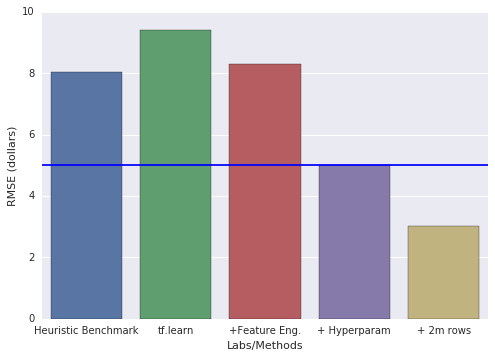

In [57]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({'Lab' : pd.Series(['1a', '2-3', '4a', '4b', '4c']),
              'Method' : pd.Series(['Heuristic Benchmark', 'tf.learn', '+Feature Eng.', '+ Hyperparam', '+ 2m rows']),
              'RMSE': pd.Series([8.026, 9.4, 8.3, 5.0, 3.03]) })

ax = sns.barplot(data = df, x = 'Method', y = 'RMSE')
ax.set_ylabel('RMSE (dollars)')
ax.set_xlabel('Labs/Methods')
plt.plot(np.linspace(-20, 120, 1000), [5] * 1000, 'b');

In [58]:
%bash
gsutil -m mv gs://${BUCKET}/taxifare/ch4/  gs://${BUCKET}/taxifare/ch4_1m/

Copying gs://single-bucket/taxifare/ch4/taxi_preproc/tmp/staging/preprocess-taxifeatures-180122-221628.1516659388.764292/dataflow_python_sdk.tar [Content-Type=application/octet-stream]...
Removing gs://single-bucket/taxifare/ch4/taxi_preproc/tmp/staging/preprocess-taxifeatures-180122-221628.1516659388.764292/dataflow_python_sdk.tar...


Copyright 2016 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License